##### 【 ML - 생선 분류 모델 만들기 】

- 주__제 : 2개 종류 생선 분류 모델 만들기
- 데이터 : ../Data/fish.csv
- 피쳐들 : 길이와 무게. 실수형
- 타__겟 : 생선종류
- 학습종류: 지도학습 -> 분류
- 학습방법: 다양한 분류 알고리즘들 => KNN 최근접이웃알고리즘

- ML 파라미터
    * 하이퍼파라미터(Hyper-Parameter)
        - 모델 성능을 좌우하는 파라미터
        - 학습 알고리즘마다 다름
        - 개발자가 직접 최적의 값 찾아야 함 => 튜닝
    * 모델파라미터(Model-Parameter)
        - 학습 후 데이터셋에 맞게 설정되는 파라미터
        - 학습 알고리즘마다 다름
        - 모델 클래스에서 자동 설정 함 => fit()메서드 실행 후 확인 가능함!
        - 파라미터이름_ : 일반적으로 이름 형태

[1] 데이터 확인 : 피쳐와 타겟 <hr>

In [ ]:
## [1-1] 모듈 로딩 및 데이터 준비
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib

## ML 학습알고리즘 모델
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
## CoW 기능 활성화 : 데이터 변경시 복사 후 처리
if not pd.get_option('copy_on_write'):
    pd.options.mode.copy_on_write = True
    print(f"CoW : {pd.get_option('copy_on_write')}")

In [ ]:
## [1-2] 데이터 로딩 및 빙어와도미 데이터만 추출
DATA_FILE='../Data/fish.csv'

## 품종, 무게, 길이 컬럼만 추출
allDF = pd.read_csv(DATA_FILE, usecols=[0,1,2])
display(allDF.head(3))

## Bream 도미, Smelt 빙어 행만 추출
fishDF = allDF[(allDF.Species == 'Bream') | (allDF.Species == 'Smelt')]

## 행인덱스 초기화
fishDF.reset_index(drop=True, inplace=True)
display(fishDF.head(3), fishDF.tail(3))
fishDF.info()

,Species,Weight,Length
0,Bream,242.0,25.4
1,Bream,290.0,26.3
2,Bream,340.0,26.5


,Species,Weight,Length
0,Bream,242.0,25.4
1,Bream,290.0,26.3
2,Bream,340.0,26.5


,Species,Weight,Length
46,Smelt,12.2,13.0
47,Smelt,19.7,14.3
48,Smelt,19.9,15.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  49 non-null     object 
 1   Weight   49 non-null     float64
 2   Length   49 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.3+ KB


In [ ]:
## [1-3] 무게와 길이 피쳐와 품종 분류 가능 여부
# pd.set_option('future.no_silent_downcasting', True)
# fishDF.loc[:, 'Species'] = fishDF.loc[:, 'Species'].replace({'Bream':0, 'Smelt':1})
# fishDF.Species = fishDF.Species.astype('category')
# fishDF.Species


In [ ]:
## 품종 컬럼 타입 변환 저장
speciesSR = fishDF.Species
fishDF.Species=speciesSR.astype('category')

In [ ]:
## 전체 데이터 타입 확인
fishDF.info()

## 카테고리 접근자 cat 사용
print(f'[categories] => {fishDF.Species.cat.categories}')
print(f'[codes]      =>\n{fishDF.Species.cat.codes}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Species  49 non-null     category
 1   Weight   49 non-null     float64 
 2   Length   49 non-null     float64 
dtypes: category(1), float64(2)
memory usage: 1.1 KB
[categories] => Index(['Bream', 'Smelt'], dtype='object')
[codes]      =>
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
dtype: int8


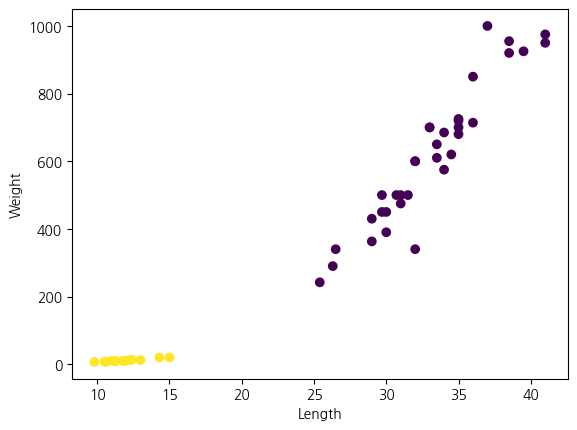

,Weight,Length
Weight,1.000000,0.960347
Length,0.960347,1.000000


In [ ]:
## - 시각화 : 산점도 => 색상을 품종에따라 다르게 설정 c 매개변수
plt.scatter(fishDF.Length, fishDF.Weight, c=fishDF.Species.cat.codes )
plt.xlabel('Length')
plt.ylabel('Weight')
plt.show()

## - 상관계수
fishDF.corr(numeric_only=True)


[2] 피쳐/데이터와 타겟/라벨 분리<hr>

In [ ]:
## 학습용 피쳐/데이터와 타겟/라벨 분리
## -> 피쳐/데이터 : 2D
featureDF = fishDF[fishDF.columns[1:]]

## -> 타겟/라벨 : 1D
targetSR  = fishDF[fishDF.columns[0]]

print(f'featureDF : {featureDF.shape} / {featureDF.ndim}D,  targetSR : {targetSR.shape} / {targetSR.ndim}D  ')



featureDF : (49, 2) / 2D,  targetSR : (49,) / 1D  


[3] 학습 진행<hr>

In [ ]:
##- 모델 인스턴스 생성
kModel = KNeighborsClassifier()
kModel

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [ ]:
##- 학습 진행 : 학습용 데이터(2D)와 타겟(1D)
##- KNN 학습 알고리즘은 메모리에 데이터와 타겟 로딩만 진행
kModel.fit(featureDF, targetSR)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


[4] 평가진행 : 테스트용 데이터/피쳐와  타겟<hr>
- 학습용 데이터 평가결과 테스트용 데이터 평가결과 비교

In [ ]:
kModel.score(featureDF, targetSR)

1.0

[5] 모델 활용 서비스<hr>

In [1]:
## 아무 도미 또는 빙어의 길이/무게 ==> 도미와 빙어 예측
#in_data = input("생선의 무게, 길이 입력(예:120 23):").strip().split()
#in_data = [ float(data)  for data in in_data ]
#in_data  = list(map(float, in_data))
in_data = [236.5, 4.1]
new_data = pd.DataFrame([in_data] , columns=fishDF.columns[1:])

kModel.predict(new_data)

NameError: name 'pd' is not defined